<a href="https://colab.research.google.com/github/AmiBuch/exp-forecasting-methods/blob/main/scripts/darts/darts_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install darts
%pip install xarray[complete]
%matplotlib inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 884.7/884.7 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 55.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 20.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 38.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.8/121.8 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.2/802.2 kB 42.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 41.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.4/223.4 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from darts import TimeSeries
import xarray as xr


In [ ]:
ds = xr.open_dataset("delhi_nov.nc")

# conversion into pandas dataframe

dataframe = ds.to_dataframe()

# Since there are 29 columns
dataframe.dtypes

# there are 40 stations per
timestamp = "2023-11-01"
filtered_df = dataframe[dataframe.index.get_level_values('Timestamp')==timestamp]

# we select a station with the least number of NaNs
nan_values_per_station = dataframe.groupby(level='station').apply(lambda x: x.isna().sum().sum()).min()

# Displaying the NaN values count for each station
print(nan_values_per_station)

# by this we see that the least number of NaN values are seen in Najafgarh, Delhi - DPCC
new_dataframe = dataframe.groupby(level='station').get_group("Najafgarh, Delhi - DPCC")
print(new_dataframe)
# We see that the columsn of Eth-Benzene, MP-Xylene, O Xylene, WD and Xylene are all Nan, thus inhibiting interpolation
# We drop these columns
col_to_drop = ["Eth-Benzene", "MP-Xylene", "O Xylene", "VWS", "Xylene"]
new_dataframe.drop(columns=col_to_drop, inplace=True)
print(new_dataframe)
print(new_dataframe.isnull().sum())

# After dropping the entire Nan columns, we can linearly interpolate
interpolated_df = new_dataframe.apply(lambda x: x.infer_objects(copy=False).interpolate(method='linear'))
print(interpolated_df.isnull().sum().sum())

# Successful interpolation, since the printed value is 0
# Now we move to the actual forecasting

time_series = {}
for column in interpolated_df.columns:
    series = interpolated_df[column]
    time_series[column] = series

# Printing individual time series
for variable, series in time_series.items():
    print(f"Variable: {variable}")
    print(series)
    print()



15545
                                               AT     BP  Benzene   CO  \
Timestamp           station                                              
2023-11-01 00:00:00 Najafgarh, Delhi - DPCC  21.1  994.2      5.0  2.5   
2023-11-01 00:15:00 Najafgarh, Delhi - DPCC  20.8  994.2      NaN  2.6   
2023-11-01 00:30:00 Najafgarh, Delhi - DPCC  20.8  994.3      NaN  2.8   
2023-11-01 00:45:00 Najafgarh, Delhi - DPCC  20.8  994.3      NaN  2.8   
2023-11-01 01:00:00 Najafgarh, Delhi - DPCC  20.6  994.2      NaN  2.8   
...                                           ...    ...      ...  ...   
2023-11-30 22:45:00 Najafgarh, Delhi - DPCC  17.0  994.7      2.1  0.2   
2023-11-30 23:00:00 Najafgarh, Delhi - DPCC  16.8  994.7      2.0  0.3   
2023-11-30 23:15:00 Najafgarh, Delhi - DPCC  16.7  994.8      2.0  0.3   
2023-11-30 23:30:00 Najafgarh, Delhi - DPCC  16.9  994.6      2.0  0.3   
2023-11-30 23:45:00 Najafgarh, Delhi - DPCC  17.0  994.5      2.0  NaN   

                               

<ipython-input-3-fe28322ba5f4>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_dataframe.drop(columns=col_to_drop, inplace=True)


Variable: RH
Timestamp            station                
2023-11-01 00:00:00  Najafgarh, Delhi - DPCC    75.3
2023-11-01 00:15:00  Najafgarh, Delhi - DPCC    76.1
2023-11-01 00:30:00  Najafgarh, Delhi - DPCC    77.3
2023-11-01 00:45:00  Najafgarh, Delhi - DPCC    77.7
2023-11-01 01:00:00  Najafgarh, Delhi - DPCC    77.9
                                                ... 
2023-11-30 22:45:00  Najafgarh, Delhi - DPCC    81.4
2023-11-30 23:00:00  Najafgarh, Delhi - DPCC    82.4
2023-11-30 23:15:00  Najafgarh, Delhi - DPCC    82.9
2023-11-30 23:30:00  Najafgarh, Delhi - DPCC    83.0
2023-11-30 23:45:00  Najafgarh, Delhi - DPCC    83.1
Name: RH, Length: 2880, dtype: float64

Variable: SO2
Timestamp            station                
2023-11-01 00:00:00  Najafgarh, Delhi - DPCC    3.8
2023-11-01 00:15:00  Najafgarh, Delhi - DPCC    3.8
2023-11-01 00:30:00  Najafgarh, Delhi - DPCC    4.2
2023-11-01 00:45:00  Najafgarh, Delhi - DPCC    4.4
2023-11-01 01:00:00  Najafgarh, Delhi - DPCC    3.7


Attempting to generate forecasts for the univariate version of the dataset, i.e. for each variable separately using darts.

# Darts

## Naive model
Here, we use the NaiveSeasonal model paired with another baseline model called NaiveDrift.
Inorder to use NaiveSeasonal, we need to define a parameter seasonality, which we will compute using ACF (Auto-correlation function). I am assuming that the seasonality is 4, considering how every week the source of pollutants (i.e. the vehicular activity, factory scehdule, et all ) are mostly human-driven and hence might follow a weekly schedule.
### NaiveSeasonal
This models tries to forecast for the season defined by the user. To automatically detect seasons (if any), we use check_seasonality() for each candidate period

Variable: AT
There is seasonality of order 96.


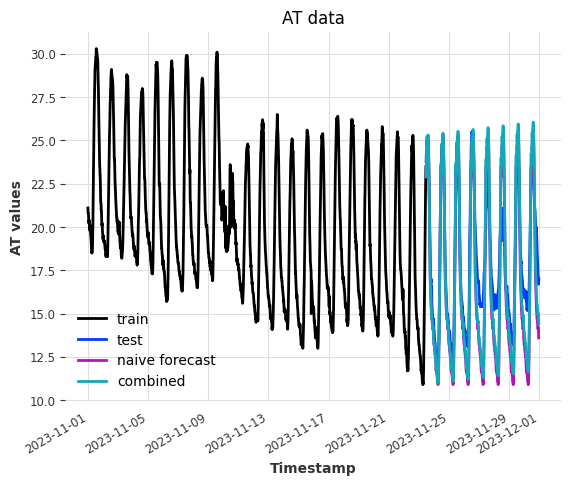

Variable: BP
There is seasonality of order 47.


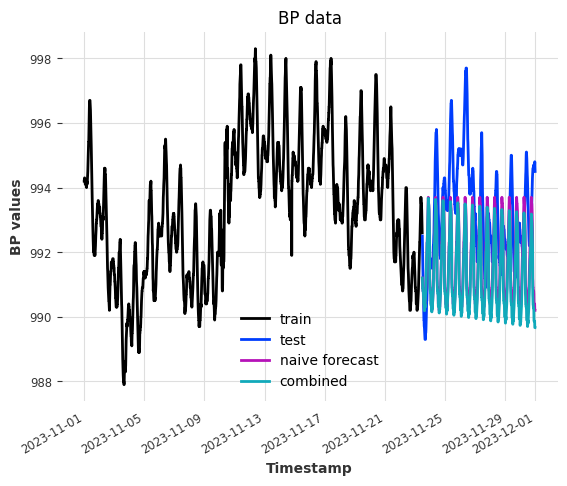

Variable: Benzene
There is seasonality of order 51.


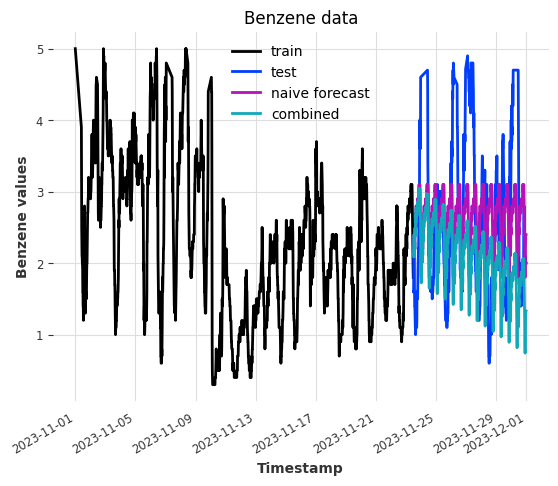

Variable: CO
There is seasonality of order 54.


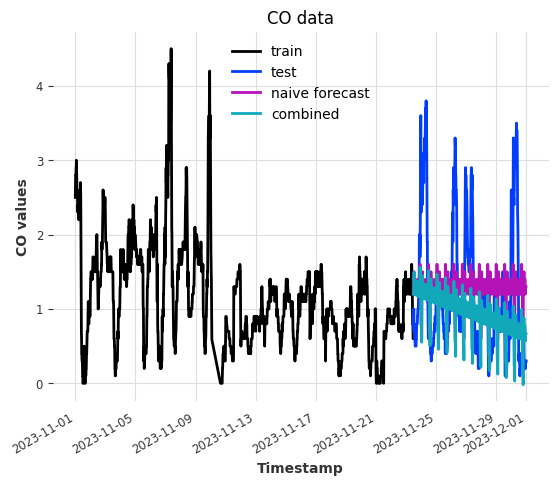

Variable: NH3
There is seasonality of order 132.


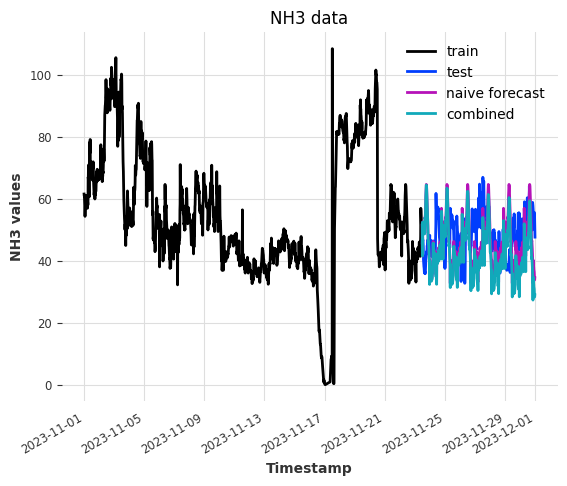

Variable: NO
There is seasonality of order 97.


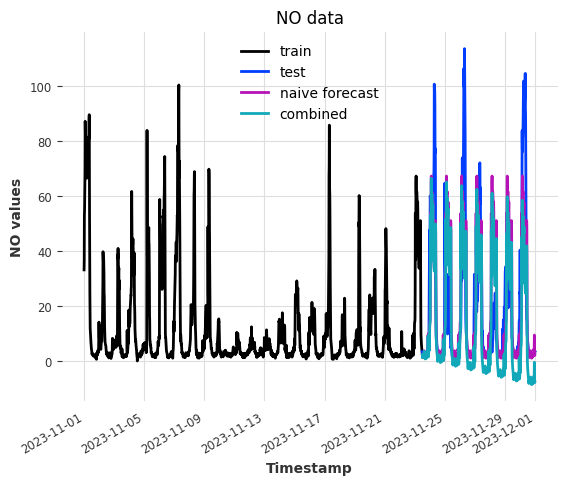

Variable: NO2
There is seasonality of order 49.


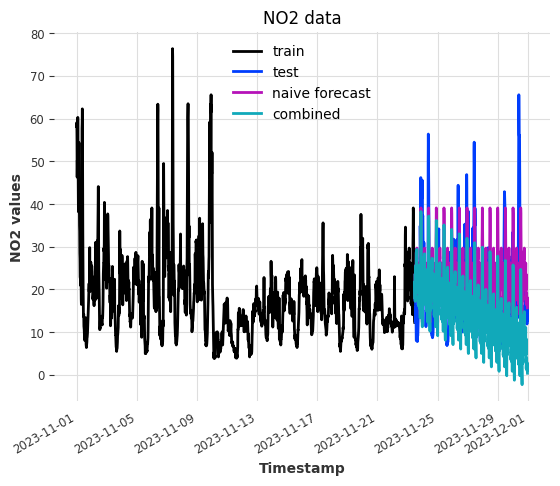

Variable: NOx
There is seasonality of order 97.


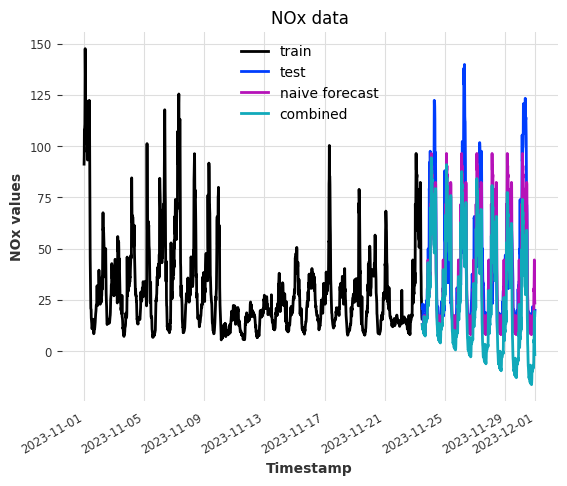

Variable: Ozone
There is seasonality of order 96.


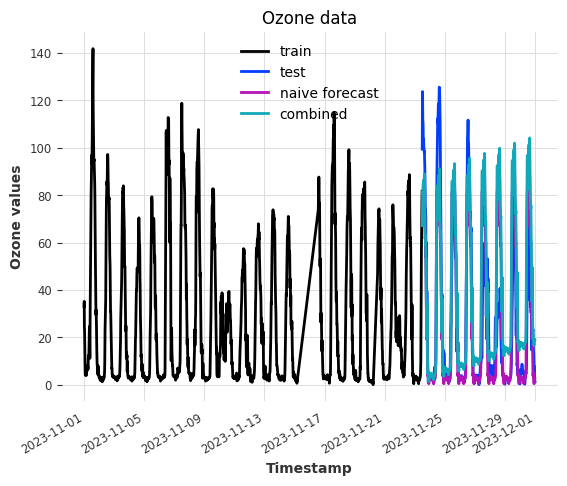

Variable: PM10
There is seasonality of order 40.


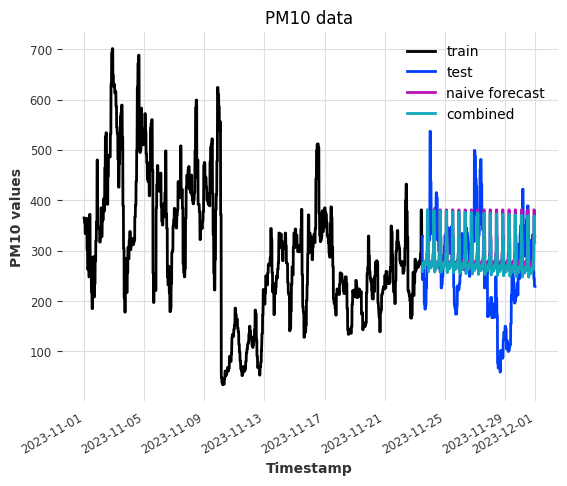

Variable: PM2.5
There is seasonality of order 93.


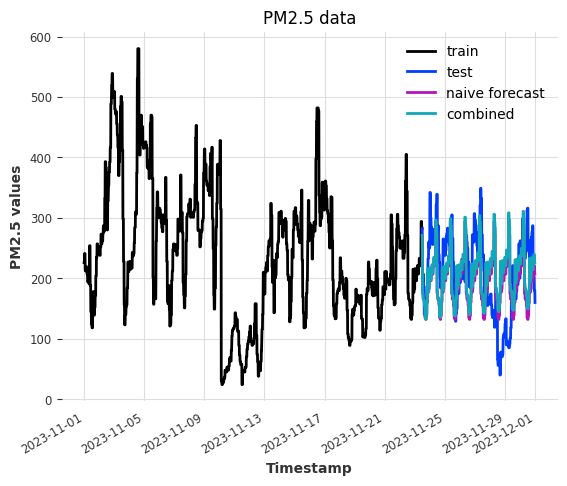

Variable: RF


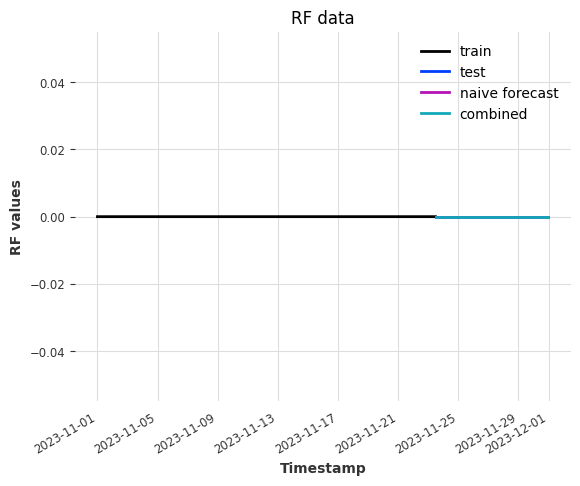

Variable: RH
There is seasonality of order 96.


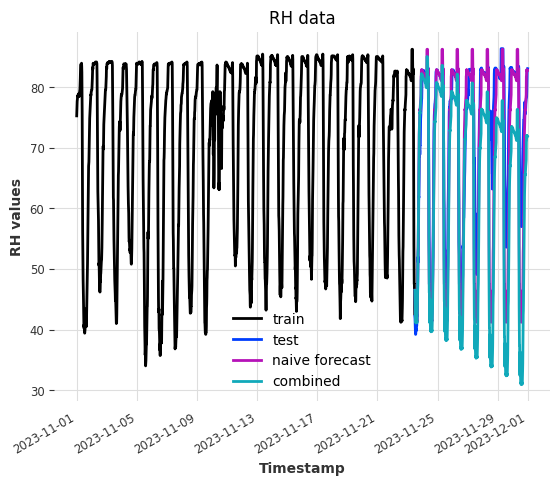

Variable: SO2
There is seasonality of order 57.


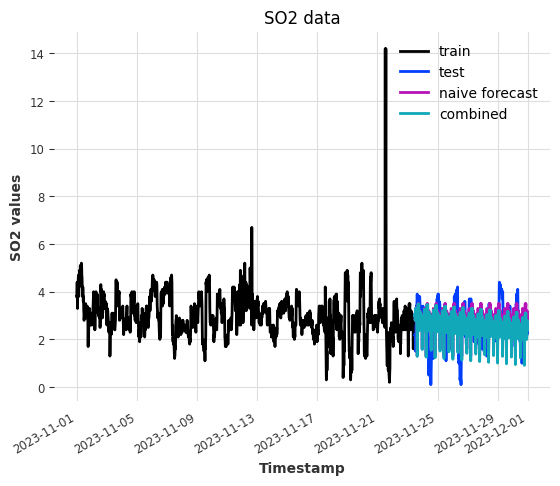

Variable: SR
There is seasonality of order 96.


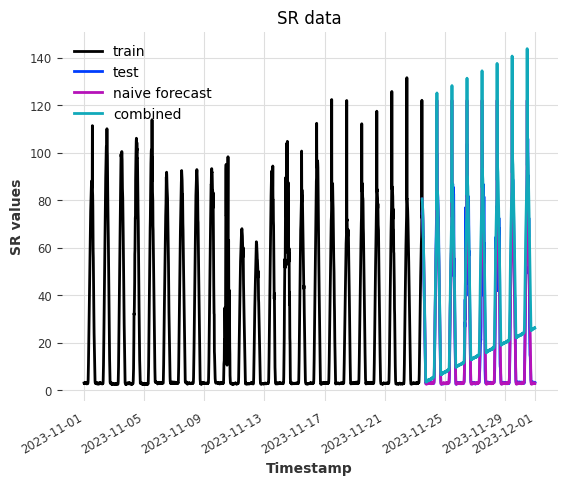

Variable: TOT-RF


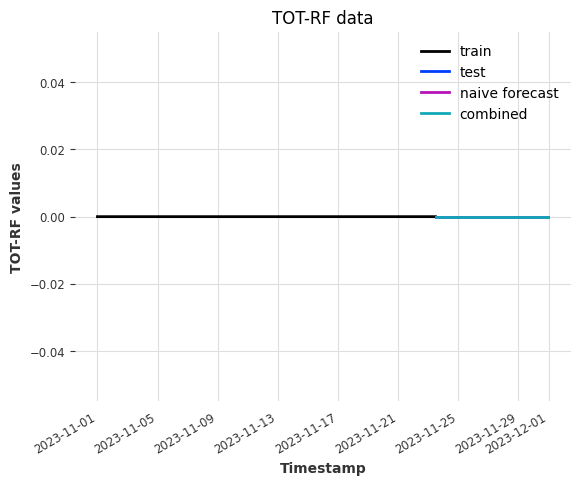

Variable: Toluene
There is seasonality of order 97.


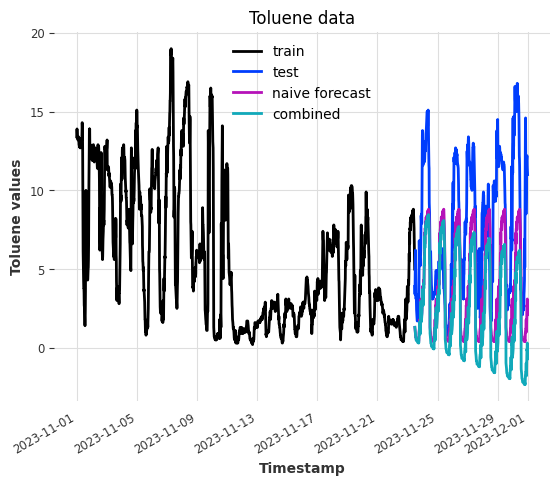

Variable: WD
There is seasonality of order 10.


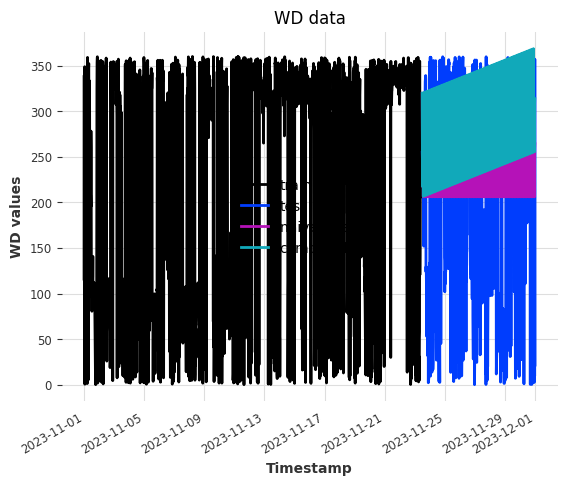

Variable: WS
There is seasonality of order 10.


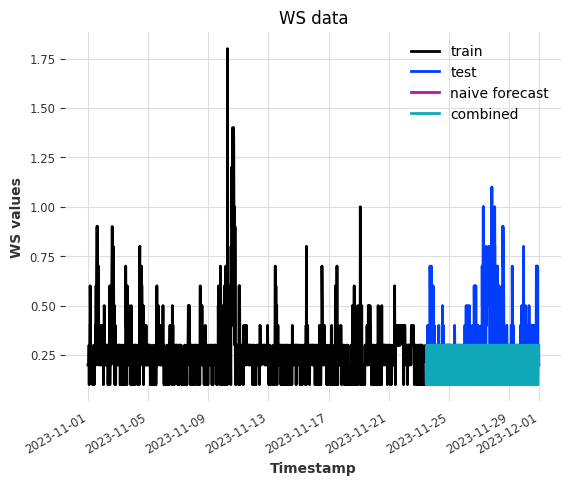

Variable: address


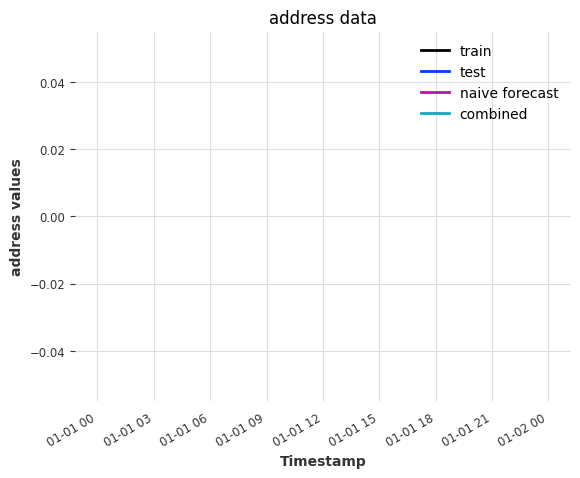

Variable: city
Variable: state
Variable: latitude


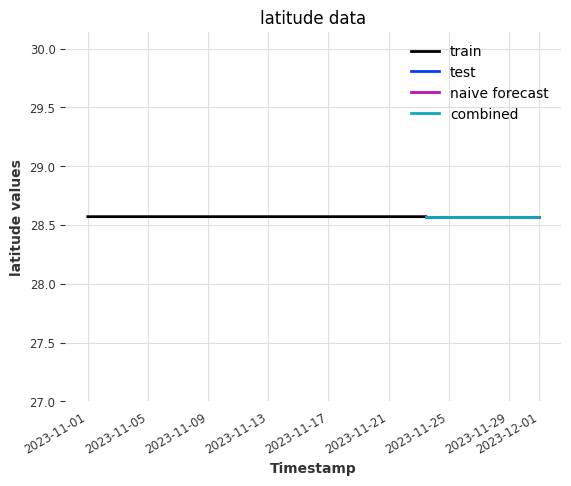

Variable: longitude


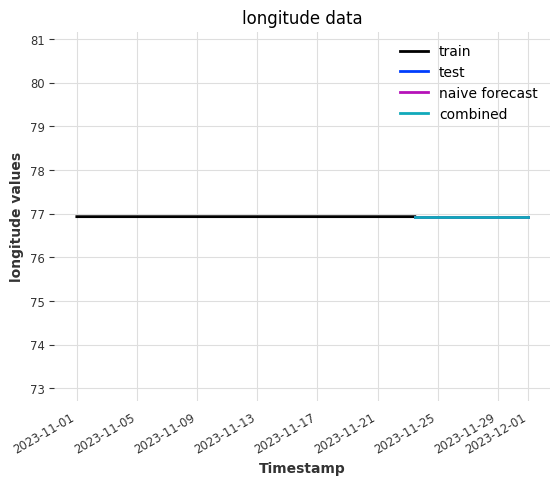

In [ ]:





from darts.utils.statistics import plot_acf, check_seasonality
from darts.models import NaiveSeasonal
from darts import TimeSeries
from darts.metrics import mape
from darts.models import ExponentialSmoothing, TBATS, AutoARIMA, Theta
from darts.models import NaiveDrift
series = AirPassengersDataset().load()
for variable, series_data in time_series.items():
    print(f"Variable: {variable}")
    if variable=='city' or variable=='state':
      # del time_series[variable]
      continue
    df = pd.Series(series_data).reset_index()
    df.columns = ['Timestamp', 'station', variable]

    df['Timestamp'] = pd.to_datetime(df['Timestamp'])

    # Set the MultiIndex
    df.set_index(['Timestamp', 'station'], inplace=True)

    # Convert DataFrame to TimeSeries
    ts = TimeSeries.from_dataframe(df.reset_index(), time_col='Timestamp', value_cols=variable, freq='15min')

    train, val = ts.split_before(0.75)
    # train.plot(label="train")
    # val.plot(label="test")
    # plt.show()
    flag = 0
    for m in range(2, 2158):
      is_seasonal, period = check_seasonality(train, m=m, max_lag = 2159, alpha=0.05)

      if is_seasonal:
          flag = 1
          print("There is seasonality of order {}.".format(period))
          seasonal_model = NaiveSeasonal(K=period)
          seasonal_model.fit(train)
          seasonal_forecast = seasonal_model.predict(int(0.25*2880))
          drift_model = NaiveDrift()
          drift_model.fit(train)
          drift_forecast = drift_model.predict(int(0.25*2880))

          combined_forecast = drift_forecast + seasonal_forecast - train.last_value()
          min_forecast = min(combined_forecast)
          if min_forecast<0:
            combined_forecast = combined_forecast - min_forecast + 1
          # drift_forecast.plot(label="drift")
          train.plot(label="train")
          val.plot(label="test")

          seasonal_forecast.plot(label="naive forecast")
          combined_forecast.plot(label="combined")
          plt.title(variable + " data")
          plt.ylabel(variable + " values")
          plt.show()
          break
    if flag==0:
      seasonal_model = NaiveSeasonal(K=2159)
      seasonal_model.fit(train)
      seasonal_forecast = seasonal_model.predict(int(0.25*2880))
      drift_model = NaiveDrift()
      drift_model.fit(train)
      drift_forecast = drift_model.predict(int(0.25*2880))

      combined_forecast = drift_forecast + seasonal_forecast - train.last_value()
      min_forecast = min(combined_forecast)
      if min_forecast<0:
        combined_forecast = combined_forecast - min_forecast + 1

      # drift_forecast.plot(label="drift")
      train.plot(label="train")
      val.plot(label="test")
      seasonal_forecast.plot(label="naive forecast")
      combined_forecast.plot(label="combined")

      plt.title(variable + " data")
      plt.ylabel(variable + " values")
      plt.show()




## Probabilistic Forecasting
### Exponential Smoothing
Monte Carlo samples in contrast to explicit confidence levels as they can be used to represent any parametric or non-parametric joint distribution over components and compute arbitrary quantiles.

Variable: AT
There is seasonality of order 96.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


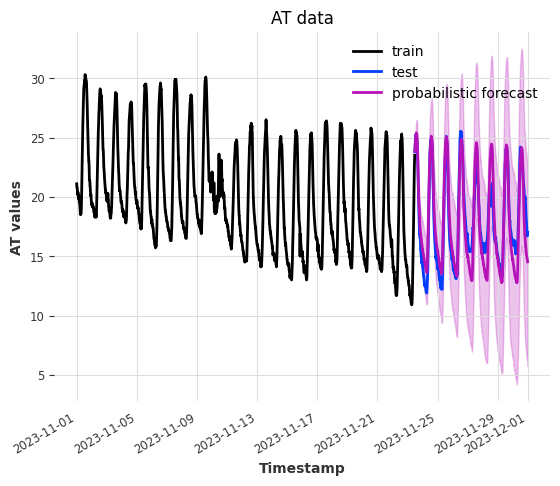

Variable: BP
There is seasonality of order 47.


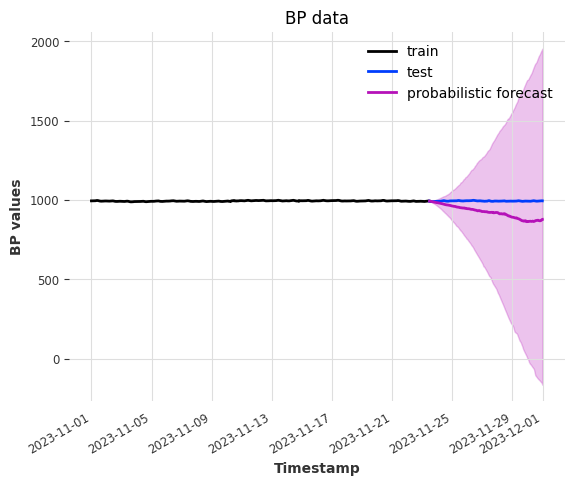

Variable: Benzene
There is seasonality of order 51.


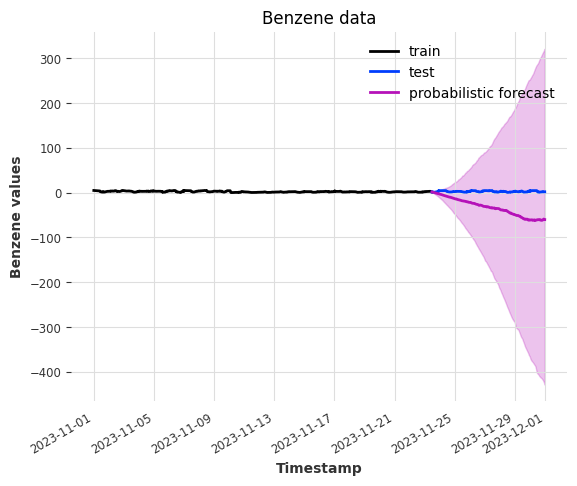

Variable: CO
There is seasonality of order 54.


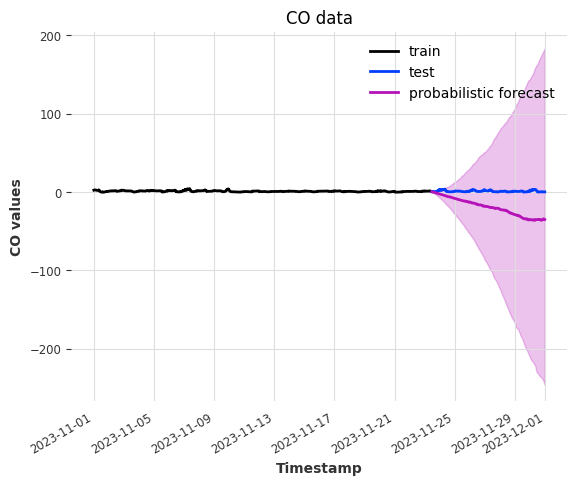

Variable: NH3
There is seasonality of order 132.


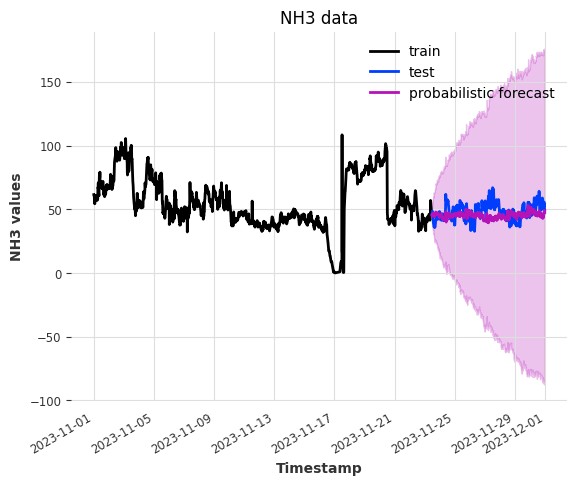

Variable: NO
There is seasonality of order 97.


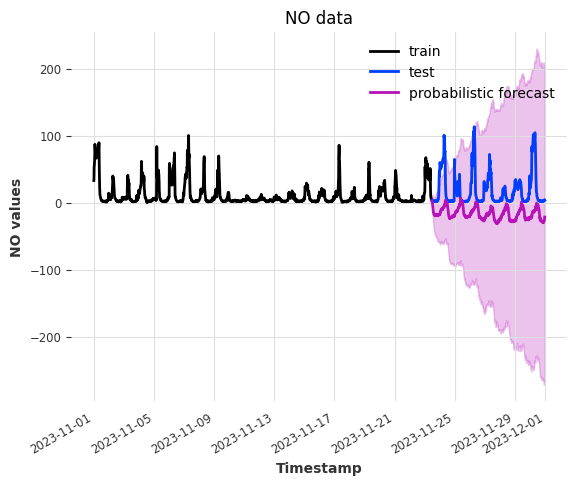

Variable: NO2
There is seasonality of order 49.


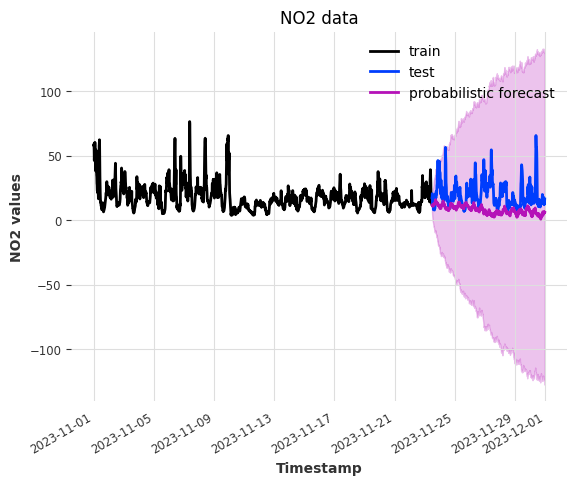

Variable: NOx
There is seasonality of order 97.


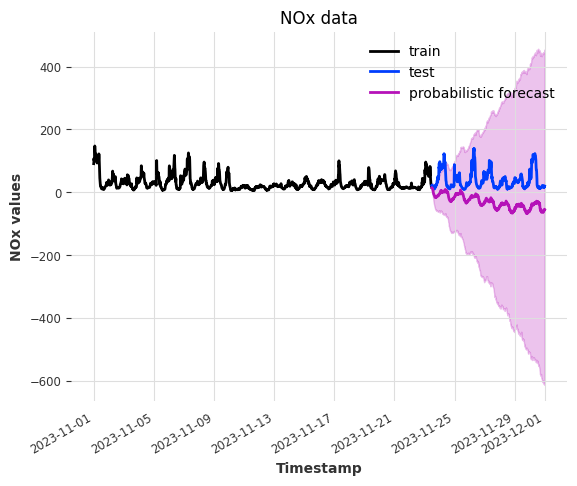

Variable: Ozone
There is seasonality of order 96.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


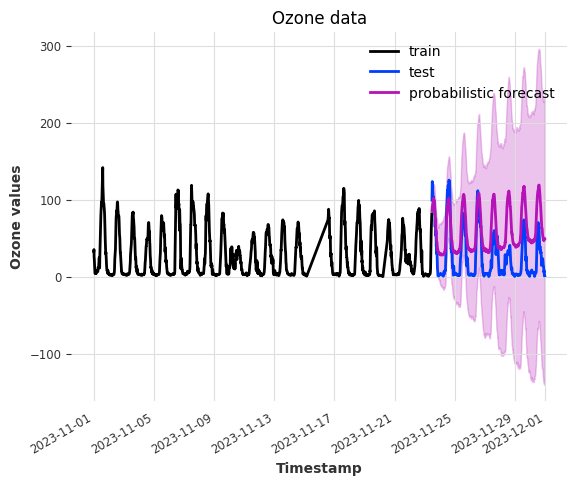

Variable: PM10
There is seasonality of order 40.


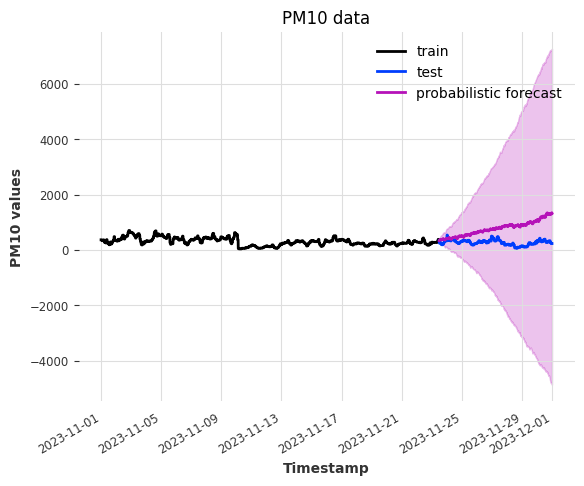

Variable: PM2.5
There is seasonality of order 93.


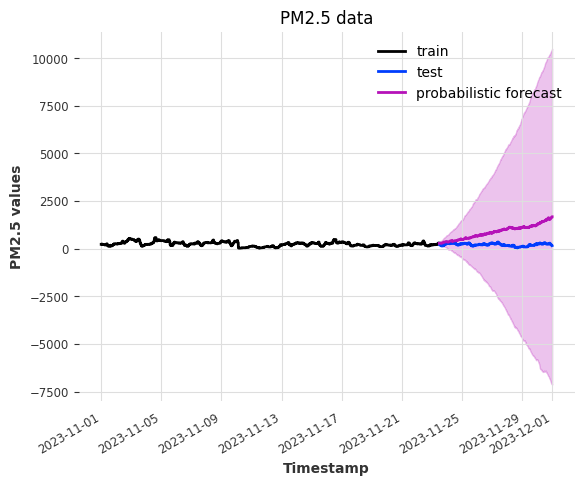

Variable: RF


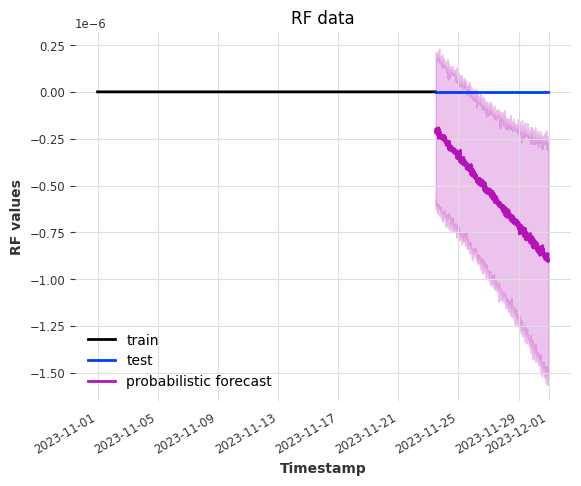

Variable: RH
There is seasonality of order 96.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


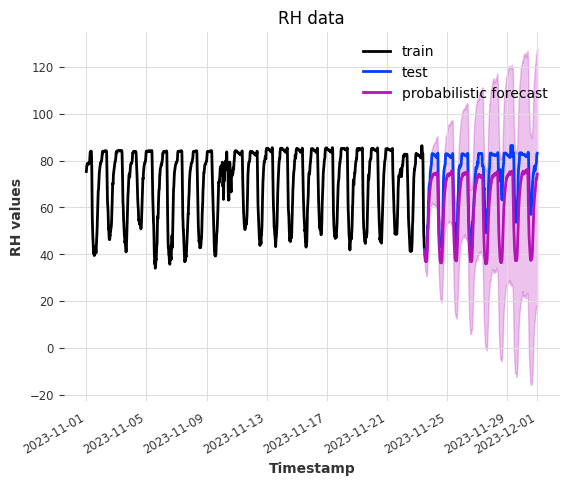

Variable: SO2
There is seasonality of order 57.


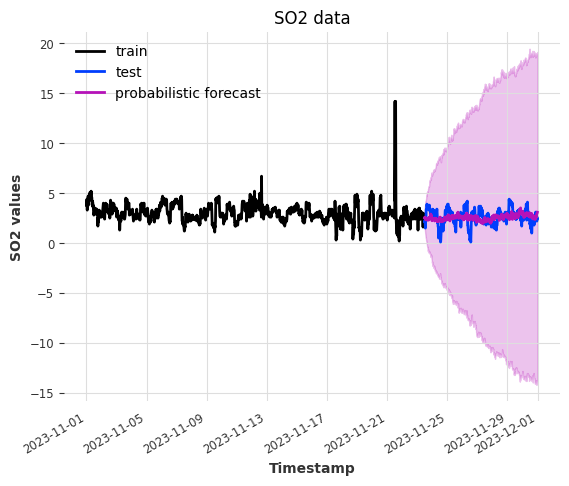

Variable: SR
There is seasonality of order 96.


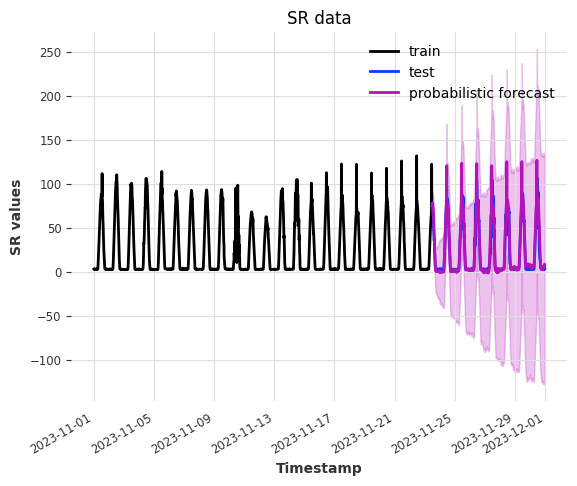

Variable: TOT-RF


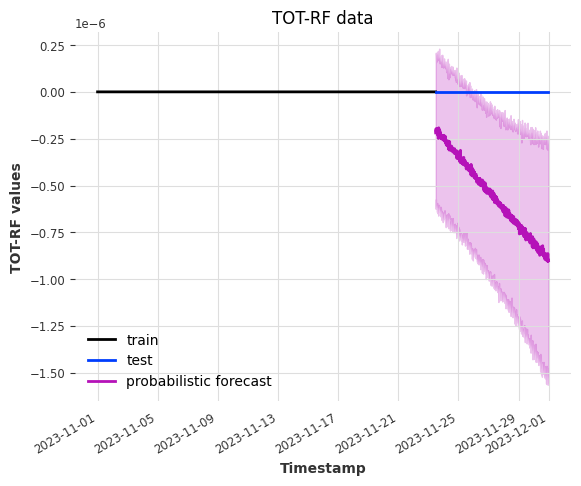

Variable: Toluene
There is seasonality of order 97.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


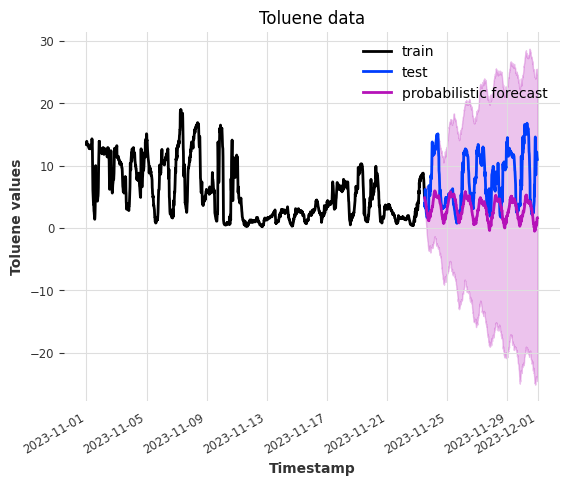

Variable: WD
There is seasonality of order 10.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


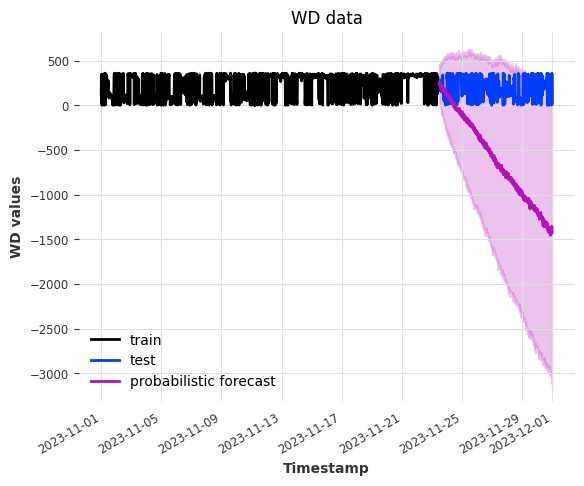

Variable: WS
There is seasonality of order 10.


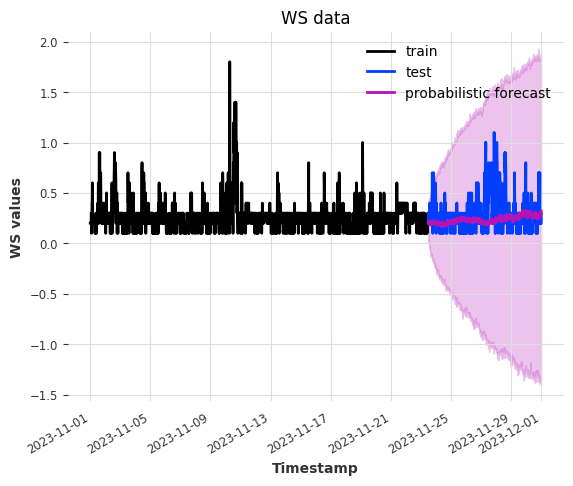

Variable: address
Variable: city
Variable: state
Variable: latitude


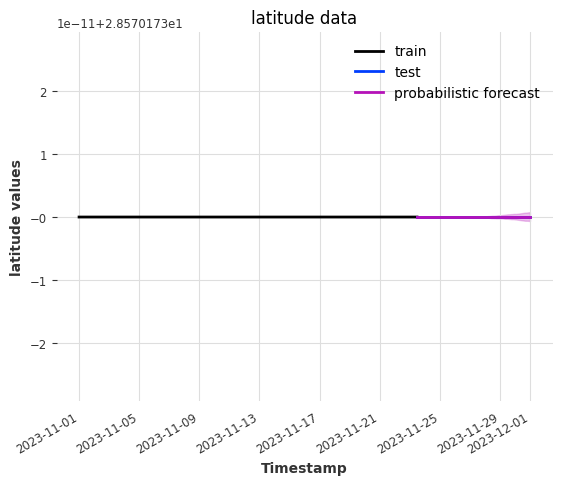

Variable: longitude


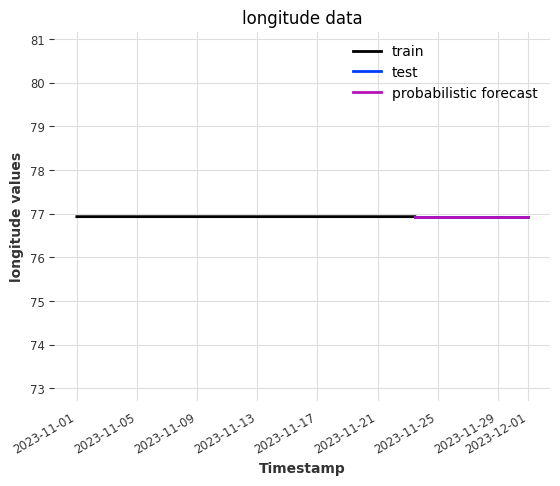

In [ ]:
for variable, series_data in time_series.items():
    print(f"Variable: {variable}")
    if variable=='city' or variable=='state' or variable=='address':
      # del time_series[variable]
      continue
    df = pd.Series(series_data).reset_index()
    df.columns = ['Timestamp', 'station', variable]

    df['Timestamp'] = pd.to_datetime(df['Timestamp'])

    # Set the MultiIndex
    df.set_index(['Timestamp', 'station'], inplace=True)

    # Convert DataFrame to TimeSeries
    ts = TimeSeries.from_dataframe(df.reset_index(), time_col='Timestamp', value_cols=variable, freq='15min')

    train, val = ts.split_before(0.75)
    flag = 0
    for m in range(2, 1000):
      is_seasonal, period = check_seasonality(train, m=m, max_lag = 2159, alpha=0.05)

      if is_seasonal:
          flag = 1
          print("There is seasonality of order {}.".format(period))
          model_es = ExponentialSmoothing(seasonal_periods=period)
          model_es.fit(train)
          probabilistic_forecast = model_es.predict(len(val), num_samples=int(0.25*2880))
          # temp_array = np.array(probabilistic_forecast).flatten()

          # min_forecast = np.min(temp_array)  # Use np.min() to find the minimum value
          # print(min_forecast)
          # if min_forecast < 0:
          #     probabilistic_forecast = probabilistic_forecast - min_forecast + 1


          train.plot(label="train")
          val.plot(label="test")
          probabilistic_forecast.plot(label="probabilistic forecast")
          plt.title(variable + " data")
          plt.ylabel(variable + " values")
          plt.show()
          break
    if flag==0:
      model_es = ExponentialSmoothing(seasonal_periods=672)
      model_es.fit(train)
      probabilistic_forecast = model_es.predict(len(val), num_samples=int(0.25*2880))
      # temp_array = np.array(probabilistic_forecast).flatten()
      # min_forecast = np.min(temp_array)  # Use np.min() to find the minimum value
      # print(min_forecast)
      # if min_forecast < 0:
      #     probabilistic_forecast = probabilistic_forecast - min_forecast + 1
      train.plot(label="train")
      val.plot(label="test")
      probabilistic_forecast.plot(label="probabilistic forecast")
      plt.title(variable + " data")
      plt.ylabel(variable + " values")
      plt.legend()
      plt.show()




